# Parameter Estimation

## Scope of current implementation

Users can:
    
    - Set estimated parameters
    - Set boundaries of optimization problem
    - Choose algorithm and set algorithm specific parameters
    - Configure report options (variables to include, name, append etc.)
    - Map arbitrary number of data files to fit at once
    - Choose between time course or steady state
      

To do:

    - Support for affected experiments section
    - Support for validation experiments



## Imports and Getting Test Model

In [1]:
%matplotlib inline
import os,glob
import site
site.addsitedir('/home/b3053674/Documents/PyCoTools')
import PyCoTools
from PyCoTools.PyCoToolsTutorial import test_models
import os
import pandas
import logging
logging.basicConfig(format = '%(levelname)s:%(message)s')
LOG=logging.getLogger()

##this can be anywhere you like
tutorial_directory = '/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial'
## module containing copasi models in string format
TM = test_models.TestModels()
kholodenko_model_string = TM.get_kholodenko_variant1() ## published kholodenko model
kholodenko_model = os.path.join(tutorial_directory, 'kholodenko_model.cps')

with open(kholodenko_model, 'w') as f:
    f.write(kholodenko_model_string)

LOG.info('written kholodenko model to {}'.format(kholodenko_model))
LOG.info('Checking that kholodenko file exists: ... {}'.format(os.path.isfile(kholodenko_model)))

INFO:root:__init__:<module>:26:Initializing PyCoTools
INFO:root:__init__:<module>:27:Initializing logging System
INFO:root:__init__:<module>:28:logging config file at: /home/b3053674/Documents/PyCoTools/PyCoTools/logging_config.conf
INFO:root:<ipython-input-1-f58b6052b3b5>:<module>:23:written kholodenko model to /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/kholodenko_model.cps
INFO:root:<ipython-input-1-f58b6052b3b5>:<module>:24:Checking that kholodenko file exists: ... True


## Simulate Synthetic Data for Demonstration

In [2]:
report= 'parameter_estimation_synthetic_data.txt'
TC=PyCoTools.pycopi.TimeCourse(kholodenko_model,start=0,end=1000,intervals=1000,step_size=1,
                            report_name = report)

## validate that its worked
LOG.info((pandas.read_csv(TC['report_name'],sep='\t').head()))

## Give fake data a meaningful name
data1 = TC['report_name']

INFO:root:<ipython-input-2-29fe06d44dcc>:<module>:6:   Time  [Mek1-PP]   [Erk2]    [Mos]  [Erk2-P]  [Erk2-PP]  [Mos-P]   [Mek1]  \
0     0   10.00000  280.000  90.0000   10.0000   10.00000  10.0000  280.000   
1     1    9.80684  279.966  89.0736   10.1341    9.90002  10.9264  280.053   
2     2    9.62736  279.938  88.1478   10.2622    9.80014  11.8522  280.087   
3     3    9.46152  279.915  87.2222   10.3845    9.70043  12.7778  280.101   
4     4    9.30931  279.898  86.2964   10.5014    9.60098  13.7036  280.096   

   [Mek1-P]  Values[Mek_tot]  Values[Erk_tot]  Values[Erk-P_tot]  \
0   10.0000              300              300            20.0000   
1   10.1402              300              300            20.0342   
2   10.2861              300              300            20.0623   
3   10.4378              300              300            20.0850   
4   10.5951              300              300            20.1024   

   Values[Mos-P_tot]  Values[Mek-P_tot]  Values[Mos_tot]  
0    

## Parameter Estimation Data Files
Rules to follow:

    - Column headings must match model variables exactly in order to be mapped. 
    - Independant variables can be mapped by appending the suffix `'_indep'` to the variable.
        - For example, if you vary the concentration of A between 0 and 10ng/mL in an experiment:
        
                Time A_indep  B   C
                t=1   0       -   - 
                t=2   0           -
                t=3  10           -
                t=4  10       -   -
    - Do not use non-asci strings (i.e. greek alpha or beta) in parameter definitions. They are minimally supported but this is unstable. 
    
 

# Setup and run single parameter estimation 

Method outline:

    1) Instantiate ParameterEstimation instance with model and data filenames
        - Ensure optional arguments are specified to the ParameterEstimation class
    2) Use `write_config_template()` method to write and configure a parameter estimation config file.
    2) Use `setup()` method
    3) Use `run()` method
    4) Use `format_results()` method (to give output results meaningful headers)

In [ ]:
## Use HookeJeeves algorithm
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        method='HookeJeeves')

In [ ]:
## Use particle swarm algorithm
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        method='ParticleSwarm')

In [ ]:
## Use GeneticAlgorith algorithm
## Set getetic algorithm parameters to low for speed of demonstration
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        method='GeneticAlgorithm', 
                                        population_size=15,
                                        number_of_generations=10)

## Write and configure item template

In [ ]:
PE.write_config_template()
LOG.info('Written template to --> {}'.format(PE['config_filename']))

### Configure manually
Now you can go to where the file was saved and modify it how you like.

    - Delete row with a parameter you want not to be included in estimation
    - Change starting values, lower bounds and upper bounds
        - If you set start values, remember to set the randomize_start_values variable to False as it defaults to True
    - Do not modify the last three columns

This is a useful way of running parameter estimations as it provides a record of how you've configured parameter estimations. 

### Configure with API
The `metabolites`, `global_parameters` and `local_parameters` arguments tell PyCoTools which parameters to include in the config file. By default all model parameters are included but these can be overridden by giving our own lists. 

For example, here we set `metabolites` and `globl_quantities` to empty lists to specify that we do not want to include them in the estimation process. We can also use the `upper_bound` and `lower_bound` arguments to constrain the estimation problem. An argument can also be given to `start_value` but parameter estimation is usually better performed multiple times with randomized start values (or with latin hypercube sampling but this is not supported)

In [3]:
config_file = os.path.join(os.path.dirname(kholodenko_model), 'KholodenkoPEConfig.xlsx')
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        method='GeneticAlgorithm', 
                                        population_size=15,
                                        number_of_generations=10,
                                        metabolites=[],
                                        global_quantities=[],
                                        lower_bound = 0.1,
                                        upper_bound = 100,
                                        config_filename = config_file)

Here we've defined a config file with only kinetic parameters estimated between the boundaries of 0.1 and 100. 

In [5]:
PE.write_config_template()

## check that the config filename exists
LOG.info(os.path.isfile(PE['config_filename']))
LOG.info( ('Your config file is here: {}'.format(PE['config_filename'])) )

INFO:PyCoTools.pycopi:pycopi:write_config_template:3091:writing config template. overwrite_config_file set to False and config_filename is /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/KholodenkoPEConfig.xlsx
INFO:root:<ipython-input-5-5d131155c0fb>:<module>:4:True
INFO:root:<ipython-input-5-5d131155c0fb>:<module>:5:Your config file is here: /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/KholodenkoPEConfig.xlsx


## Setup and run parameter estimation

In [6]:
PE.setup()

It can sometime be helpful to open the GUI and manually check that you' set all the options currectly. Run the next cell to open the model:

In [ ]:
import os
os.system('CopasiUI {}'.format(kholodenko_model))
##  remember to close the model before continuing

## Run with CopasiSE

In [8]:
PE.run() # will take some time depending on arguments to ParameterEstimation

<PyCoTools.pycopi.Run instance at 0x7f871f034830>

In [9]:
## lets take a look at the parameter estimation results
pe_data= pandas.read_csv(PE.kwargs['report_name'],sep='\t') 

LOG.info( 'These are your estimated parameters:\n\n{}'.format(pe_data.transpose())  )

INFO:root:<ipython-input-9-ddb43e660a3f>:<module>:4:These are your estimated parameters:

                                             0
(phosphorylation of MAPKK).KK3        0.711185
(MAPKKK activation).K1               77.283300
(dephosphorylation of MAPK-PP).V9    38.425600
(phosphorylation of MAPK).k7          0.625048
(phosphorylation of MAPK-P).k8       24.289400
(MAPKKK inactivation).KK2            37.160700
(MAPKKK inactivation).V2              8.499530
(phosphorylation of MAPKK).k3         0.203128
(phosphorylation of MAPKK-P).k4       0.298982
(dephosphorylation of MAPKK-PP).KK5   1.168010
(dephosphorylation of MAPK-PP).KK9   70.350100
(dephosphorylation of MAPKK-P).KK6   94.623700
(phosphorylation of MAPKK-P).KK4      0.231324
(MAPKKK activation).V1               10.503700
(MAPKKK activation).Ki               36.982500
(phosphorylation of MAPK).KK7        67.852300
(dephosphorylation of MAPK-P).KK10   27.602000
(phosphorylation of MAPK-P).KK8      58.730400
(dephosphorylatio

## Multiple Data Files

### Change a parameter value  
PyCoTools can easily handle multiple data files by giving `ParameterEsimation` a list of data file paths. Lets simulate some more data.

Lets first change a model parameter so both sets of simulated data are not identical:

In [19]:
## Original value of Mek1-PP at time 0 is 10 
# #Use InsertParameters to change it to 20
I=PyCoTools.pycopi.InsertParameters(kholodenko_model,parameter_dict={'(MAPKKK activation).V1':45})

## Set to True for manual check
manual_check = False
if manual_check:
    os.system('CopasiUI {}'.format(kholodenko_model))

### Simulate second time course

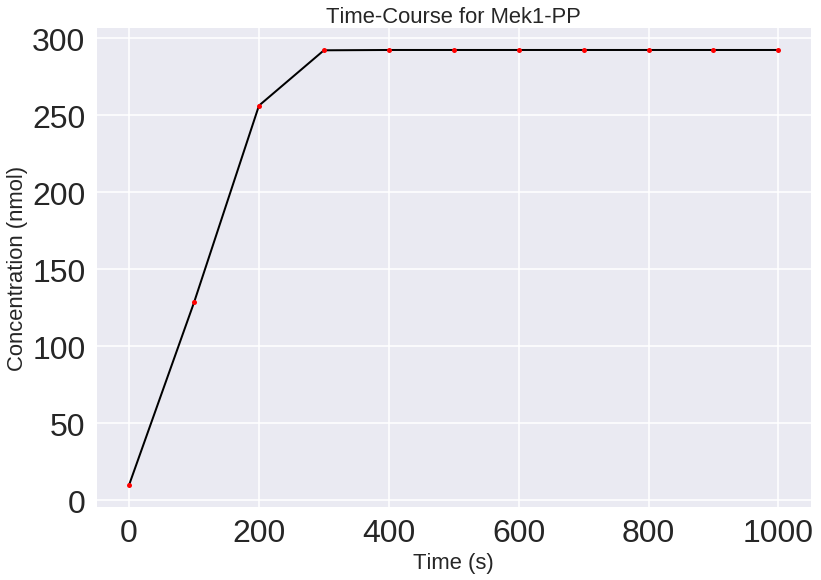

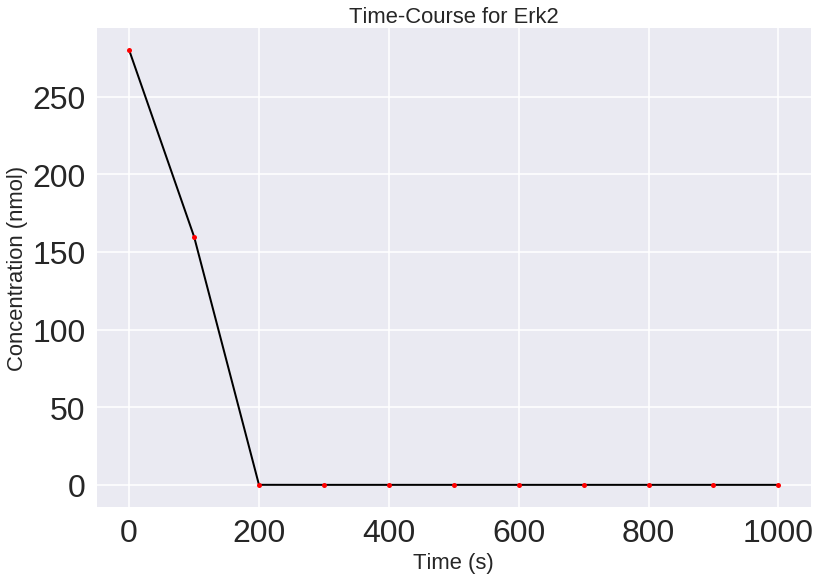

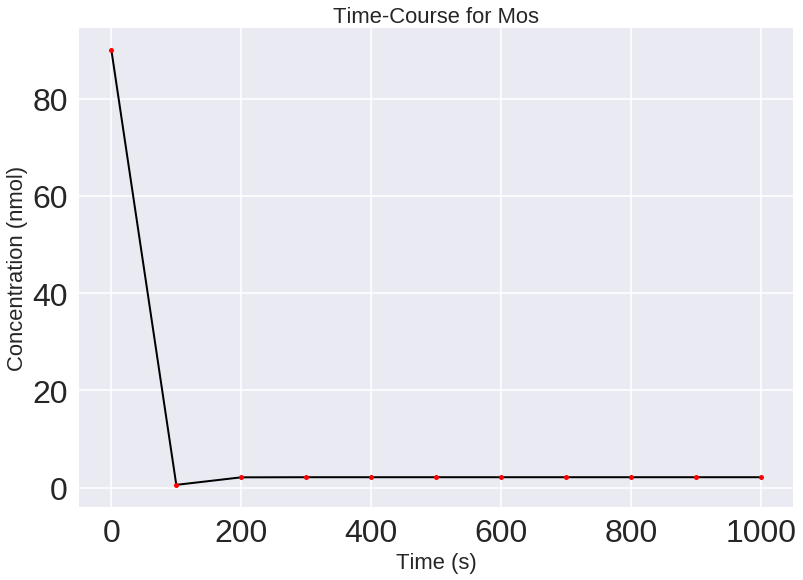

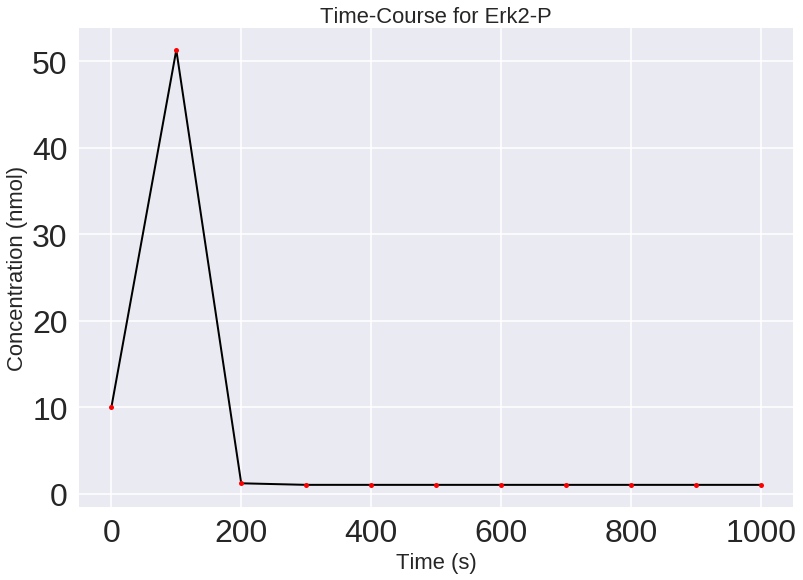

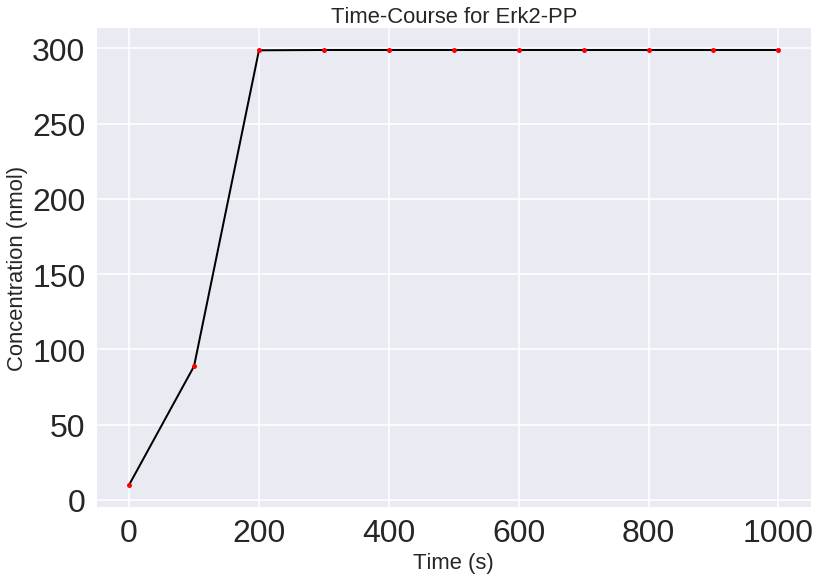

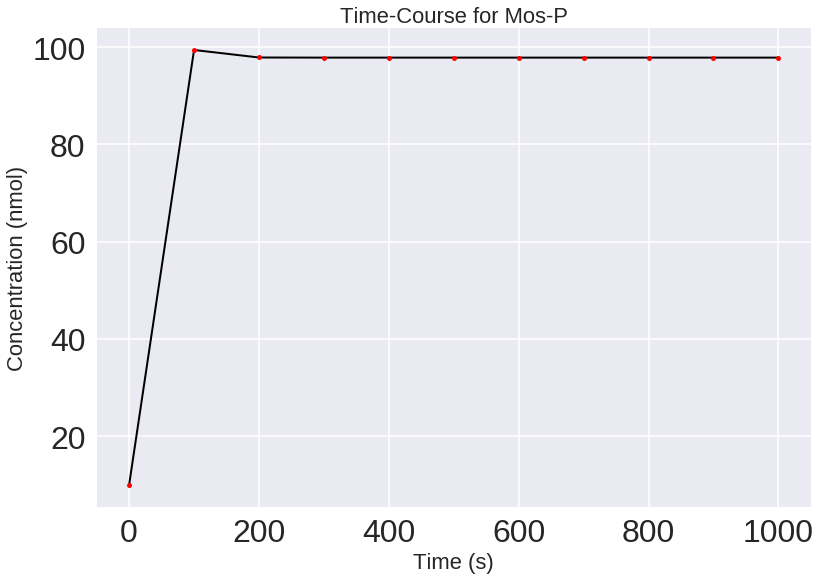

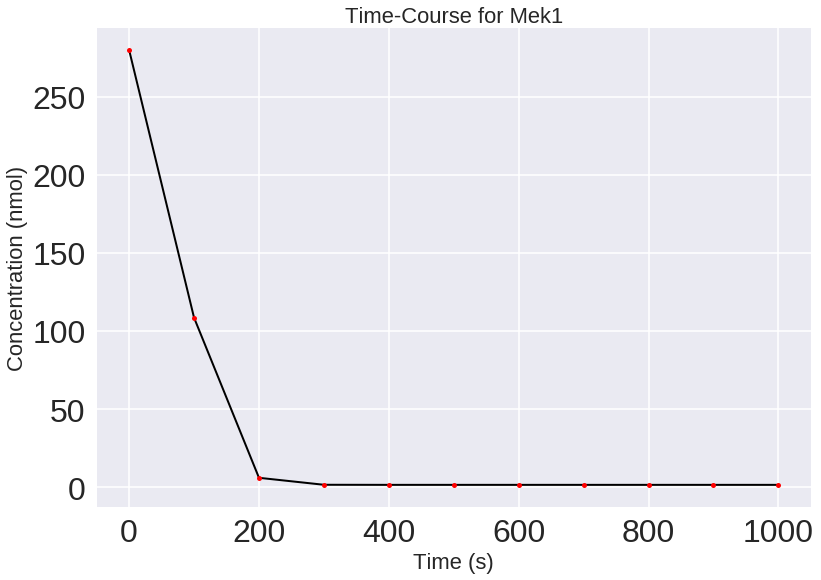

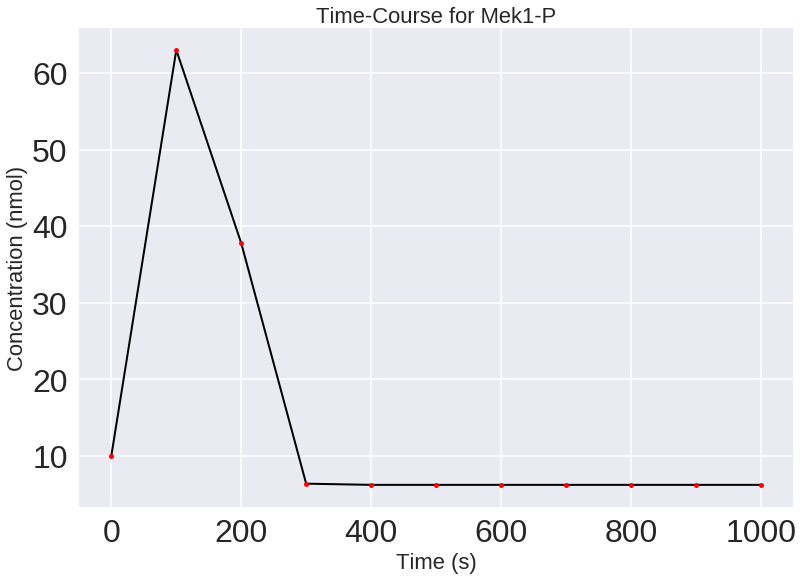

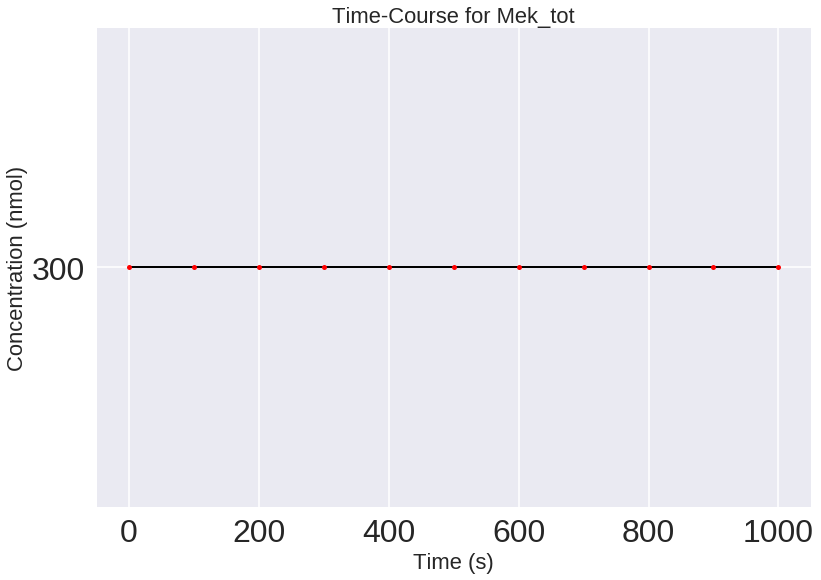

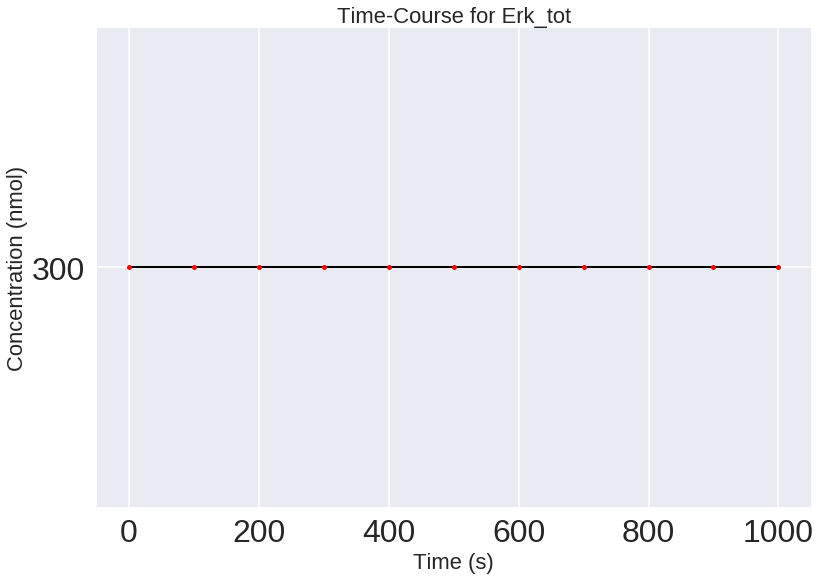

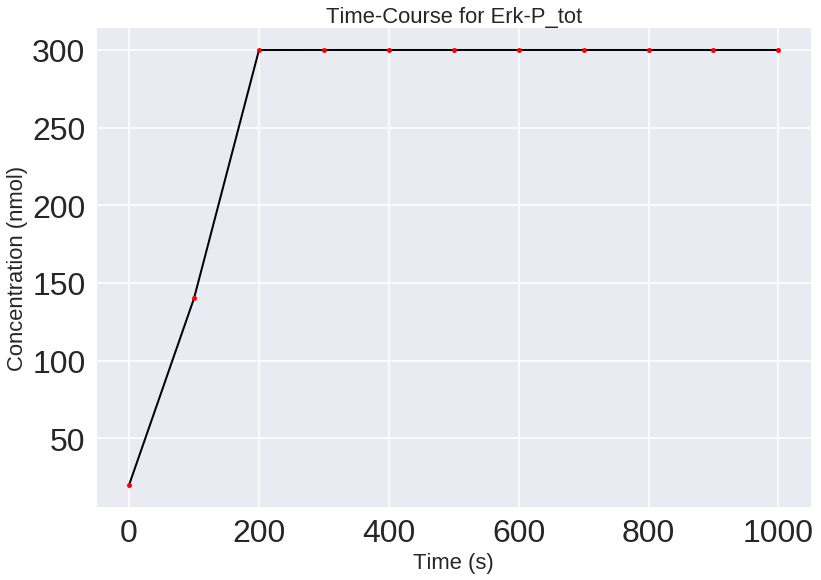

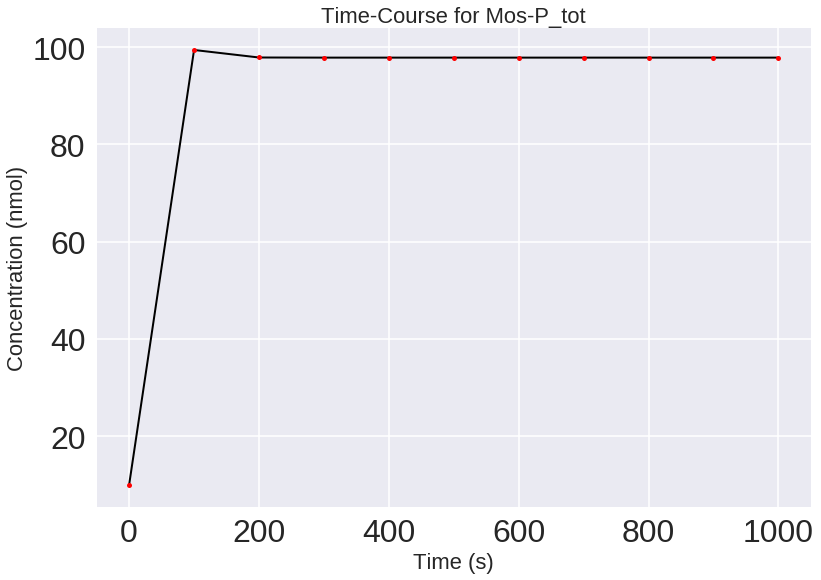

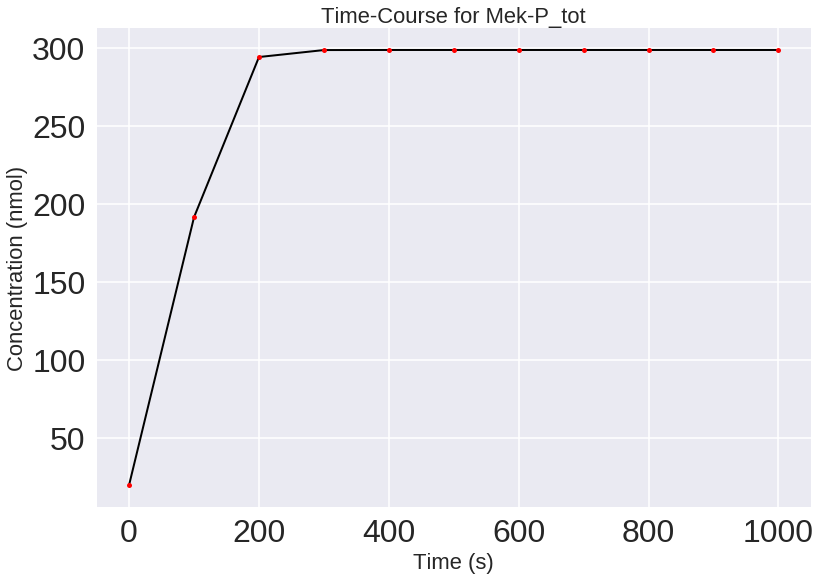

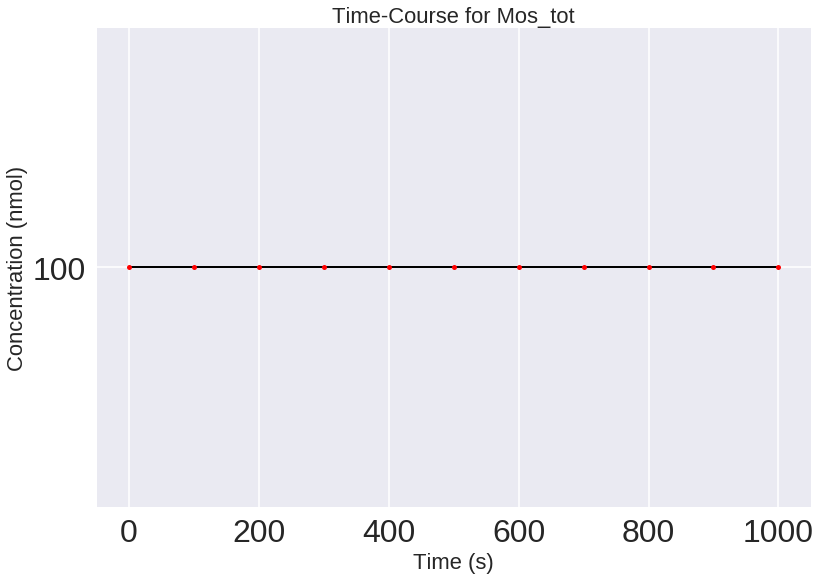

In [20]:
report= 'parameter_estimation_synthetic_data2.txt'
TC=PyCoTools.pycopi.TimeCourse(kholodenko_model,
                               end=1000,
                               intervals=10,
                               step_size=100,
                               report_name = report,
                               plot=True)


## Give fake data a meaningful name
data2 = TC['report_name']

## Setup parameter estimation with two data files
Pass a list of properly configured COPASI data files rather than a single string. 

In [ ]:
report = 'parameter_estimation_data2.txt'
config_file = os.path.join(os.path.dirname(kholodenko_model), 'kholodenko_config_file2.xlsx')
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,[data1,data2],method='GeneticAlgorithm',
                       population_size = 5,number_of_generations= 20,report_name = report,
                       metabolites=[], global_quantities=[], lower_bound=0.1, 
                      upper_bound=100, config_filename=config_file)
PE.write_config_template()
PE.setup()
PE.run()
PE.format_results()

### Check the parameter estimation data:

In [ ]:
df = pandas.read_csv(PE['report_name'],sep='\t').transpose()
LOG.info('Estimated parameters are:\n{}'.format(df)) 

# Visualization 
Use the `Plot` keyword to visualize the data

In [25]:
from PyCoTools.pycopi import ParameterEstimation 

report = 'parameter_estimation_data2.txt'
config_file = os.path.join(os.path.dirname(kholodenko_model), 'kholodenko_config_file3.xlsx')
PE=ParameterEstimation(kholodenko_model,[data1,data2],method='GeneticAlgorithm',
                       population_size = 50,number_of_generations= 300,report_name = report,
                       metabolites=[], global_quantities=[], lower_bound=0.1, 
                       upper_bound=100, config_filename=config_file, plot=True)
PE.write_config_template()
PE.setup()
PE.run()
PE.format_results()

SyntaxError: keyword argument repeated (<ipython-input-25-21eb1b01506f>, line 8)

## Insert the parameters and simulate
Insert the estimated parameters into the model for further analysis

In [ ]:
pe_data = pandas.read_csv(report,sep='\t')

PyCoTools.pycopi.InsertParameters(kholodenko_model,parameter_path = pe_data['report_name'],
                                  index = 0)

os.system('CopasiUI {}'.format(kholodenko_model))

